### Q.2. Implement CNN(VGG16) model for Predicting Invasive Ductal Carcinoma (IDC) in Breast Cancer Histology Images 

#### <a>https://www.kaggle.com/paultimothymooney/breast-histopathology-images.</a>
#### For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the parameters of the CNN model for Focal loss function. For better training performance, you can use batch-normalization and dropout if necessary.

#### (i) Plot a comparative loss curve for at least 50 epochs. (ii)Print confusion matrix, calculate classification metrics such as precision, recall, F1-score, IoU and accuracy on test dataset and ROC curve.Q.2. Implement CNN(VGG16) model for Predicting Invasive Ductal Carcinoma (IDC) in Breast Cancer Histology Images (https://www.kaggle.com/paultimothymooney/breast-histopathology-images).For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the parameters of the CNN model for Focal loss function. For better training performance, you can use batch-normalization and dropout if necessary.

#### (i) Plot a comparative loss curve for at least 50 epochs. (ii)Print confusion matrix, calculate classification metrics such as precision, recall, F1-score, IoU and accuracy on test dataset and ROC curve.

In [1]:
import numpy as np 
import cv2 
from PIL import Image
from matplotlib import pyplot as plt 
# plt.style.use("ggplot") 

import pandas as pd

import tensorflow as tf 
from tensorflow.keras import models, layers 

import os 
from tqdm import *
from random import sample 

In [2]:
tf.config.list_physical_devices("GPU")

2021-11-09 18:15:57.297140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 18:15:57.302420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 18:15:57.302863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
EPOCHS = 50
BATCH_SIZE = 32 
LR = 0.01 

WIDTH = HEIGHT = 50
CHANNELS = 3 

In [4]:
class BreastDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size = BATCH_SIZE, dim = (HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):

        self.data = df 
        self.batch_size = batch_size 
        self.idx = self.data.index.tolist()
        self.dim = dim 

        self.channels = n_channels
        self.shuffle = shuffle 

        self.on_epoch_end() 

    def __len__(self):
        return int(np.ceil(len(self.data)/self.batch_size)) 

    def __getitem__(self, idx):
        # if (idx+1)*self.batch_size > len(self.idx):
        #     self.batch_size = len(self.idx) - idx*self.batch_size 

        # idx = self.idx[idx*self.batch_size : (idx+1)*self.batch_size] 
        # batch = [self.idx[k] for k in idx]
        batch = sample(self.idx, self.batch_size)
        x, y = self.__data_generation(batch)
        return x, y 

    def on_epoch_end(self):
        # self.idx = np.arange(len(self.idx)) 
        if self.shuffle:
            np.random.shuffle(self.idx) 

    def load_img(self, img_path):
        img = np.asarray(Image.open(img_path))/256.
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, self.dim)
        return img


    def __data_generation(self, batch):
        x = np.empty((self.batch_size, *self.dim, self.channels))
        y = np.empty((self.batch_size, 1))

        for idx, batch_idx in enumerate(batch):

            x[idx, :] = self.load_img(self.data["ImageId"][batch_idx])
            y[idx, :] = int(self.data["Class"][batch_idx])

        return x, y 

In [5]:
path = "Q2_dataset"
dirs = os.listdir(path)
dirs.remove("IDC_regular_ps50_idx5")
path2dirs = [os.path.join(path, i) for i in dirs]

imagePaths = []
classId = [] 

for dirpath in tqdm(path2dirs, desc="Extracting Paths", ncols=100):
    subdirs = os.listdir(dirpath)

    path2subdirs = [os.path.join(dirpath, i) for i in subdirs]
    
    for idx, subdirpath in enumerate(path2subdirs):  
        img_paths = os.listdir(subdirpath)
        imagePaths += [os.path.join(subdirpath, i) for i in img_paths]
        classId += [subdirs[idx]]*len(img_paths) 

df = pd.DataFrame({
    "ImageId": imagePaths, 
    "Class": classId
})

df.head()

Extracting Paths: 100%|██████████████████████████████████████████| 279/279 [00:00<00:00, 822.36it/s]


,ImageId,Class
0,Q2_dataset/12871/1/12871_idx5_x1001_y451_class...,1
1,Q2_dataset/12871/1/12871_idx5_x1101_y651_class...,1
2,Q2_dataset/12871/1/12871_idx5_x1001_y301_class...,1
3,Q2_dataset/12871/1/12871_idx5_x951_y301_class1...,1
4,Q2_dataset/12871/1/12871_idx5_x1051_y601_class...,1


In [6]:
def visualize(samples, n_samples, model=None):
    x, y = samples 
    fig, ax = plt.subplots(n_samples, 1, figsize = (20, 20), constrained_layout=True)

    if model is not None:
        pred = model.predict(x) 
        for i in range(n_samples):
            ax[i].imshow(x[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_title("Ground Truth: {}, Predicted: {}".format(y[i], pred[i]), color="white")

    else :
        for i in range(n_samples): 
            ax[i].imshow(x[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_title("Ground Truth: {}".format(y[i]), color="white")


2021-11-09 18:15:58.726502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 18:15:58.727032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 18:15:58.727385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 18:15:58.727665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

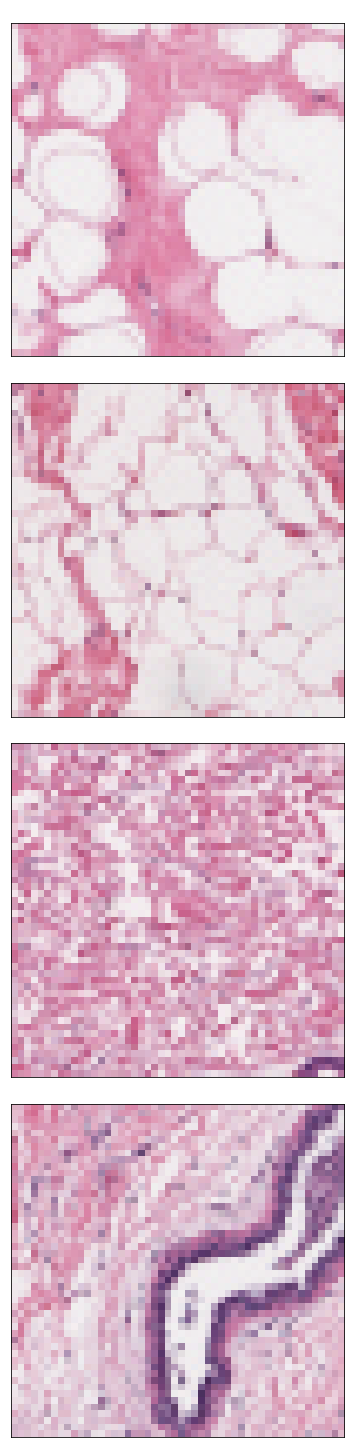

In [7]:
trialGen = BreastDataGenerator(df = df)
v_samples = next(iter(trialGen))
visualize(v_samples, n_samples=4)

In [8]:
class ConvLayer(tf.keras.layers.Layer):
    
    def __init__(self, numKernels, kernelSize, strides, padding = "same", n_convs=3, activation = "relu", pool=True):
        super(ConvLayer, self).__init__() 
        
        self.pool = pool

        self.convLayers = models.Sequential([
            layers.Conv2D(
                numKernels, kernelSize, strides=strides, 
                padding=padding, activation=activation
            )
        ] * n_convs)

        self.pooling = layers.MaxPool2D(pool_size=(2, 2))

    def call(self, x):

        x = self.convLayers(x)
        if self.pool == True:
            x = self.pooling(x)         
        return x 


class VGGNet(tf.keras.models.Model):

    def __init__(self, n_classes=2):
        super(VGGNet, self).__init__()

        self.conv1 = ConvLayer(numKernels=64, kernelSize=(3, 3), strides=1, n_convs=2)
        self.conv2 = ConvLayer(numKernels=128, kernelSize=(3, 3), strides=1, n_convs=2)
        self.conv3 = ConvLayer(numKernels=256, kernelSize=(3, 3), strides=1, n_convs=3)
        self.conv4 = ConvLayer(numKernels=512, kernelSize=(3, 3), strides=1, n_convs=3)
        self.conv5 = ConvLayer(numKernels=512, kernelSize=(3, 3), strides=1, n_convs=3) 

        self.flat = layers.Flatten()
        self.dense = layers.Dense(n_classes, activation="sigmoid") 


    def call(self, input_tensor):

        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.flat(x)
        x = self.dense(x)

        return x

    def build_graph(self, inShape = (HEIGHT, WIDTH, CHANNELS)):
        x = layers.Input(shape=inShape)
        return models.Model(inputs = [x], outputs = self.call(x)) 

In [9]:
vggModel = VGGNet()
vggModel.build_graph().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv_layer (ConvLayer)       (None, 25, 25, 64)        1792      
_________________________________________________________________
conv_layer_1 (ConvLayer)     (None, 12, 12, 128)       73856     
_________________________________________________________________
conv_layer_2 (ConvLayer)     (None, 6, 6, 256)         295168    
_________________________________________________________________
conv_layer_3 (ConvLayer)     (None, 3, 3, 512)         1180160   
_________________________________________________________________
conv_layer_4 (ConvLayer)     (None, 1, 1, 512)         2359808   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

In [10]:
df = df[:50000]
lenDf = len(df)
split = int(0.8*lenDf)

X_df = df[:split]
Y_df = df[split:] 

trainGen = BreastDataGenerator(df = X_df)
valGen = BreastDataGenerator(df = Y_df)

vggModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics = ["accuracy"]
)
vggHist = vggModel.fit(trainGen, epochs=EPOCHS, validation_data=valGen)

2021-11-09 18:16:01.396093: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300
2021-11-09 18:16:01.934211: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-09 18:16:02.401426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
1250/1250 [==============================] - 408s 325ms/step - loss: 0.7741 - accuracy: 0.4941 - val_loss: 0.5056 - val_accuracy: 0.0000e+00
Epoch 2/50
1250/1250 [==============================] - 243s 195ms/step - loss: 0.5543 - accuracy: 0.5136 - val_loss: 0.5080 - val_accuracy: 1.0000
Epoch 3/50
1250/1250 [==============================] - 137s 109ms/step - loss: 0.5500 - accuracy: 0.5800 - val_loss: 0.5055 - val_accuracy: 1.0000
Epoch 4/50
1250/1250 [==============================] - 124s 99ms/step - loss: 0.5529 - accuracy: 0.7784 - val_loss: 0.5025 - val_accuracy: 1.0000
Epoch 5/50
1250/1250 [==============================] - 108s 86ms/step - loss: 0.5515 - accuracy: 0.5264 - val_loss: 0.5062 - val_accuracy: 0.0000e+00
Epoch 6/50
1250/1250 [==============================] - 94s 75ms/step - loss: 0.5492 - accuracy: 0.4576 - val_loss: 0.5042 - val_accuracy: 1.0000
Epoch 7/50
1250/1250 [==============================] - 86s 69ms/step - loss: 0.5479 - accuracy: 0.5040 - va

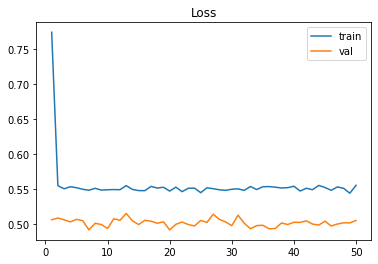

In [15]:
# plt.figure(figsize = (10, 10))
plt.plot(np.arange(1, EPOCHS+1), vggHist.history["loss"], label="train")
plt.plot(np.arange(1, EPOCHS+1), vggHist.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()
plt.show()

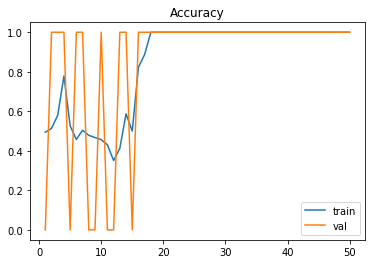

In [16]:
plt.plot(np.arange(1, EPOCHS+1), vggHist.history["accuracy"], label="train")
plt.plot(np.arange(1, EPOCHS+1), vggHist.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()
plt.show()